In [1]:
import pandas as pd
import numpy
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
#read in box_scores csv file
box_scores = pd.read_csv('box_scores.csv',index_col=0)
# change data types for id's
box_scores = box_scores.astype({'Game ID':'str','Team ID':'str'})

Compare goals of home and away teams

In [24]:
#create goals df by merging home rows against away rows on game id
goals = pd.merge(left=box_scores[box_scores['Home']==1][['goals','Game ID']], 
                 right=box_scores[box_scores['Home']==0][['goals','Game ID']],
                 how='inner', 
                 on='Game ID')
#rename goals columns as home and away
goals = goals.rename(columns={'goals_x':'Home','goals_y':'Away'})
goals.head()

,Home,Game ID,Away
0,2,2017020001,7
1,2,2017020068,1
2,2,2017020087,5
3,4,2017020108,3
4,7,2017020168,1


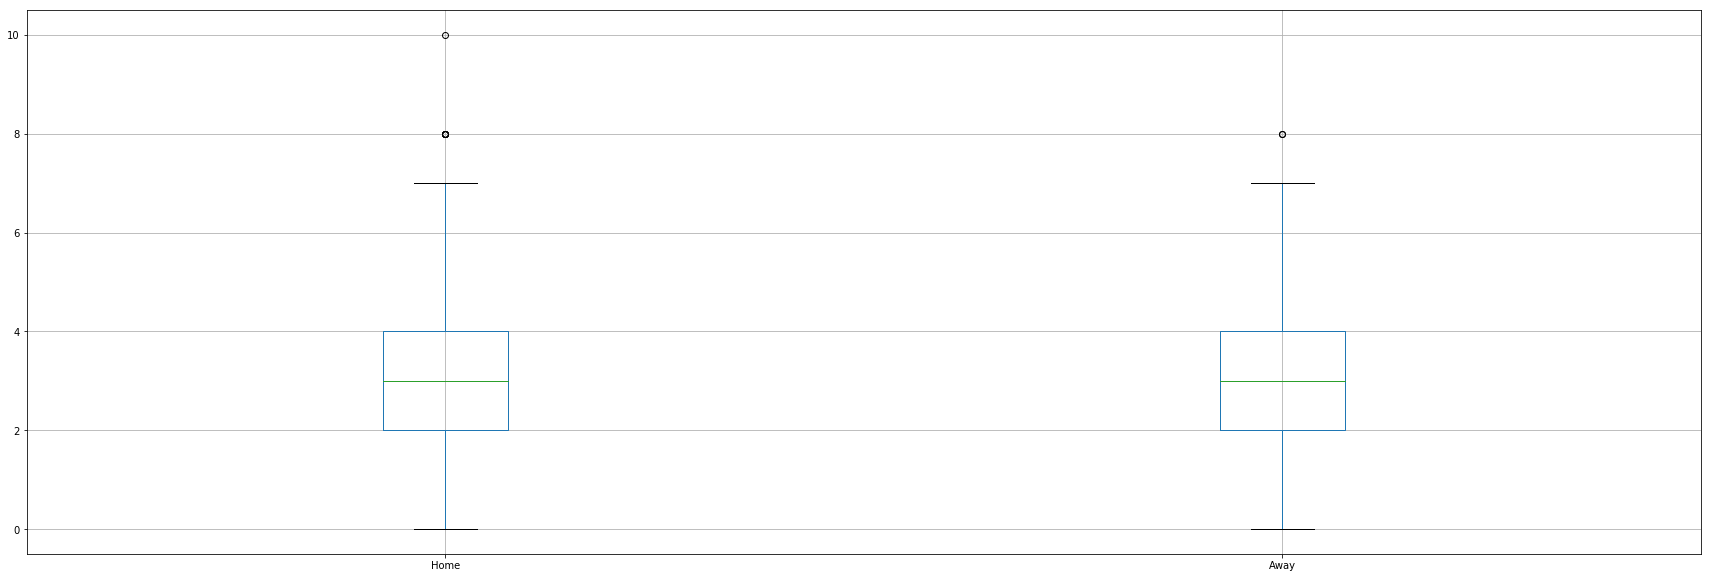

In [25]:
goals.boxplot(['Home','Away'],figsize=(30,10))

Home and Away goals have similar features, both have a median of 3 goals, minimum of 0 and upper quartiles of 7 goals,
home teams have outliers ranging to 10 goals, let look at the distribution of goals with a dist plot

C:\Users\CiaranCarroll\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\CiaranCarroll\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


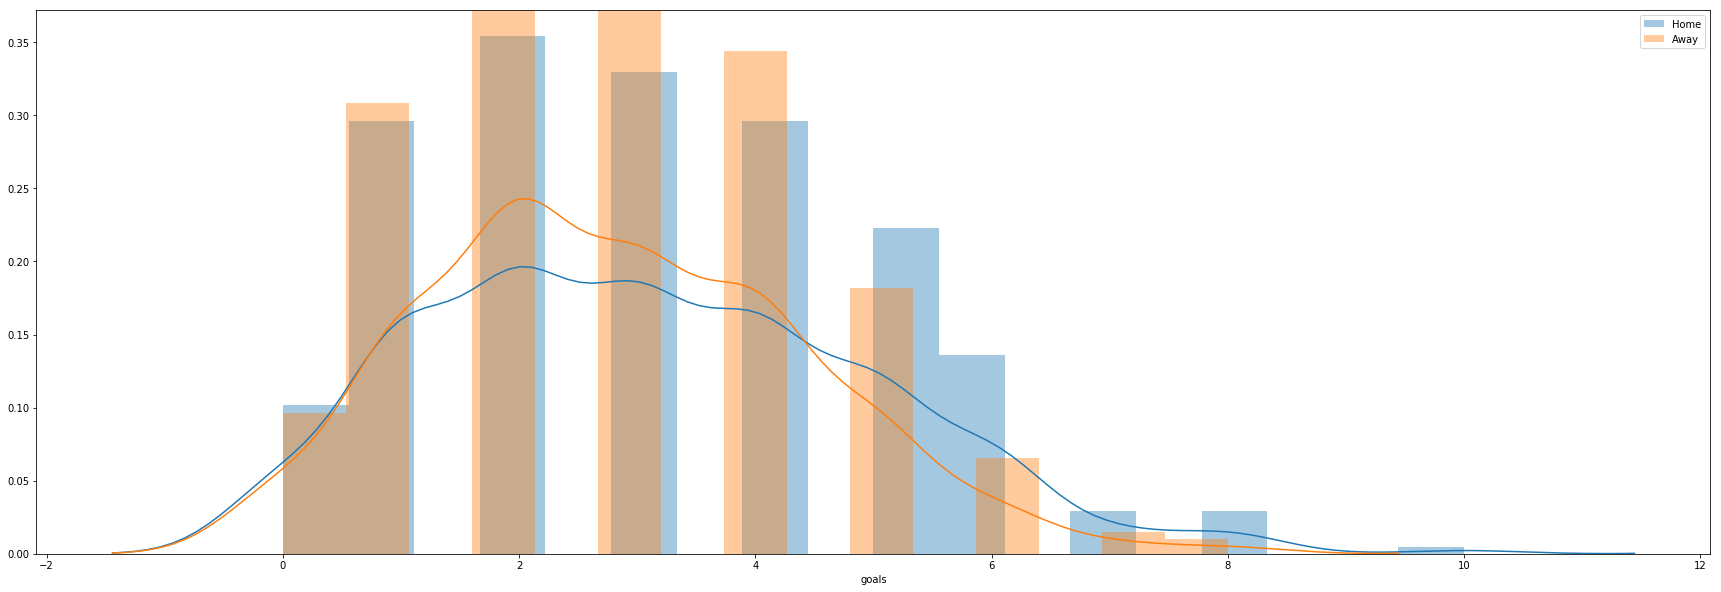

In [26]:
plt.figure(figsize=(30,10))
sns.distplot(box_scores[box_scores['Home']==1]['goals'], label='Home')
sns.distplot(box_scores[box_scores['Home']==0]['goals'], label='Away')
plt.legend()

In [28]:
goals.describe()

,Home,Away
count,371.000000,371.000000
mean,3.107817,2.808625
std,1.869880,1.578070
min,0.000000,0.000000
25%,2.000000,2.000000
50%,3.000000,3.000000
75%,4.000000,4.000000
max,10.000000,8.000000


On average home teams will score 3.1 goals per game while away team will score 2.8 but does home vs away make a significant difference for goals scored?

In [29]:
#conduct a dependent t-test on home and away goals
from scipy import stats
stats.ttest_rel(goals['Home'], goals['Away'])

Ttest_relResult(statistic=2.3485498590780294, pvalue=0.01937227591983728)

With a p value of less than 0.05 we can reject the null hypothesis that there is no statistically significant difference between the average home and away team goal count.

Lets check out the relationship between wins and home/away

In [48]:
home_wins = box_scores[box_scores['Home']==1][['Win','Game ID','Team ID']]

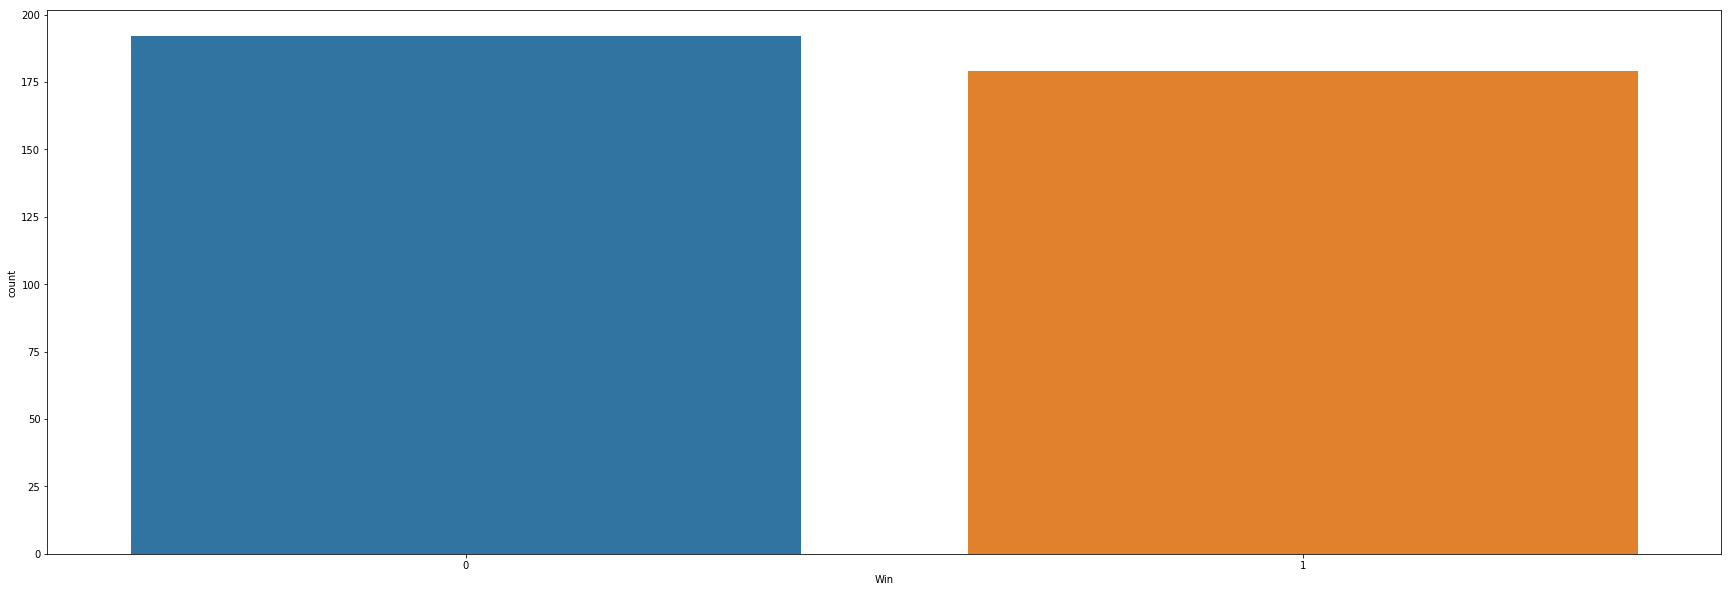

In [49]:
plt.figure(figsize=(30,10))
sns.countplot(x='Win',data=home_wins)

Home teams in the 2017 season lost more games than they won, lets use a proportions Z test to see if there is a significant difference between wins for home and away teams

In [55]:
home_wins.groupby('Win')['Game ID'].count()

Win
0    192
1    179
Name: Game ID, dtype: int64

Out of 371 games the away team won 192 and the home team won 179

In [58]:
import statsmodels.api as sm
z_score, p_value = sm.stats.proportions_ztest([192, 179], [371, 371])
print('z_score: '+str(z_score))
print('p_value: '+str(p_value))


z_score: 0.9544900276786581
p_value: 0.33983565477930466


In [61]:
stats.norm.ppf(1-(0.05/2))

1.959963984540054

As the z_score is smaller than the critical value at 95% confidence interval we accept the Null Hypothesis that there is no significant difference between home and away wins

Lets look at penalties

C:\Users\CiaranCarroll\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


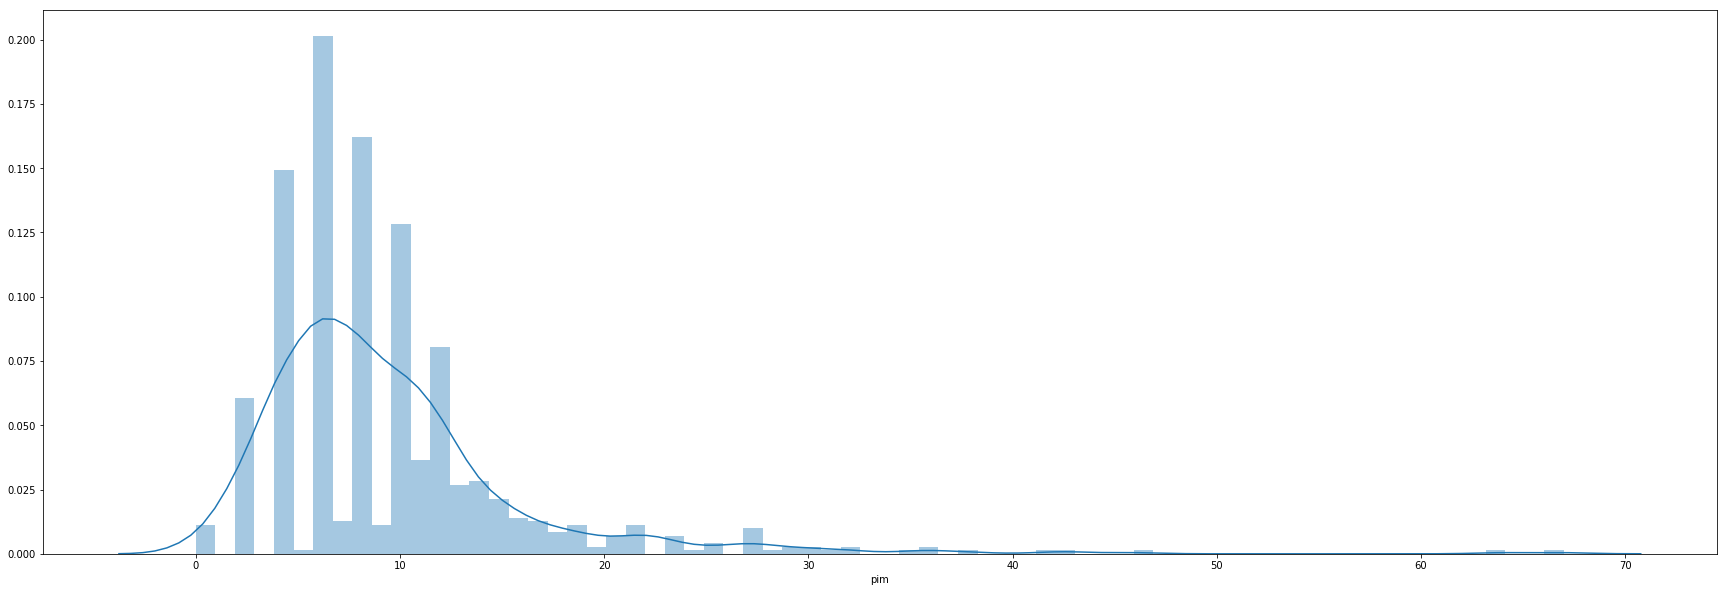

In [62]:
plt.figure(figsize=(30,10))
sns.distplot(box_scores['pim'],bins=70)

In [64]:
box_scores['pim'].describe()

count    742.000000
mean       9.440701
std        6.797325
min        0.000000
25%        6.000000
50%        8.000000
75%       12.000000
max       67.000000
Name: pim, dtype: float64

In [66]:
box_scores['pim'].median()

8.0

Most frequently a team has 6 penalty minutes in a game, the median of all games being 8, the mean is 9 due to a skewed distribution (one team had 67 penalty minutes in one game?!)

In [68]:
box_scores[box_scores['Game ID'] == box_scores[box_scores['pim']==67]['Game ID'].values[0]]

,goals,pim,shots,powerPlayPercentage,powerPlayGoals,powerPlayOpportunities,faceOffWinPercentage,blocked,takeaways,giveaways,hits,Team ID,Home,Game ID,Win,name,shots_blocked,MISSED_SHOT,Total Shots
140,2,67,28,20.0,1,5,42.3,8,1,8,13,20,0,2017020275,0,Calgary Flames,16,20,64
401,8,64,27,66.7,4,6,57.7,16,7,5,11,17,1,2017020275,1,Detroit Red Wings,8,10,45


Turns out Clagary Flames and Detroit Redwings was a pretty heated game, 111 pims according to the article https://www.sportsnet.ca/hockey/nhl/flames-wings-game-111-pims-five-game-misconducts/

Lets look at shots (on goal, missed and blocked), a popular metric is the Corsi which compares shots for and against and can be represented as a integer or percentage

For example Team A have 66 shots or goal Team B have 55:
Corsi Team A = 66-55 = 11
Corsi Team A% = 66/(66+55) = 55%
Corsi Team B = 55-66 = -11
Corsi Team B% = 55/(66+55) = 45%

In [100]:
#create corsi df
corsi_df =box_scores[['Total Shots','Game ID','Win','Home','goals']]
#create df of shots against by inverting home identifier
shots_against = box_scores[['Total Shots','Game ID','Home','Team ID']]
shots_against['Home']=shots_against['Home'].apply(lambda x: (x*-1)+1)
#rename Total Shots column to Shots Against
shots_against = shots_against.rename(columns={'Total Shots':'Shots Against'})
#merge shots_blocked df with corsi_df
corsi_df = pd.merge(corsi_df, shots_against, how = 'inner', left_on = ['Game ID','Home'], right_on = ['Game ID','Home'])
corsi_df['Corsi %']=(corsi_df['Total Shots']/(corsi_df['Total Shots']+corsi_df['Shots Against']))*100
corsi_df.sort_values('Game ID').head()


C:\Users\CiaranCarroll\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,Total Shots,Game ID,Win,Home,goals,Shots Against,Team ID,Corsi %
0,71,2017020001,0,1,2,53,10,57.258065
24,53,2017020001,1,0,7,71,52,42.741935
49,72,2017020002,0,1,4,56,19,56.250000
75,56,2017020002,1,0,5,72,5,43.750000
123,58,2017020003,0,0,0,80,22,42.028986


C:\Users\CiaranCarroll\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\CiaranCarroll\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


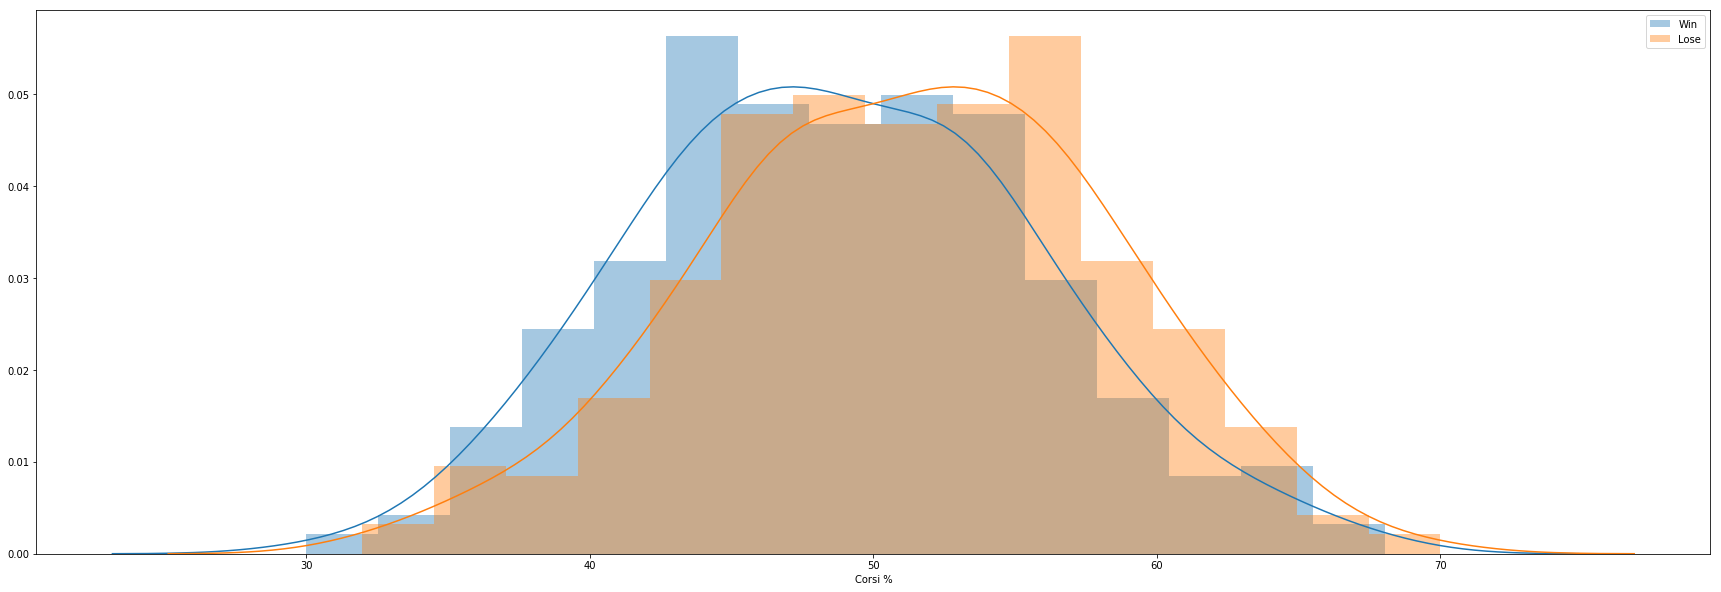

In [101]:
plt.figure(figsize=(30,10))
sns.distplot(corsi_df[corsi_df['Win']==1]['Corsi %'],label='Win')
sns.distplot(corsi_df[corsi_df['Win']==0]['Corsi %'],label='Lose')
plt.legend()

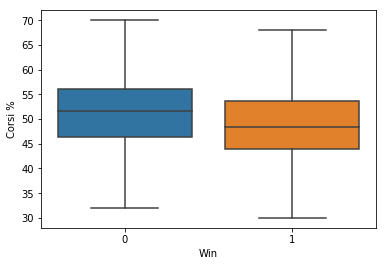

In [102]:
sns.boxplot(x='Win',y='Corsi %',data=corsi_df)

Winners tend to have a lower number of shots, resulting in a lower Corsi % this would indicate conversion rates for shots to goals for winners must be much higher

In [103]:
corsi_df['Conversion %']=(corsi_df['goals']/corsi_df['Total Shots'])*100

C:\Users\CiaranCarroll\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\CiaranCarroll\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


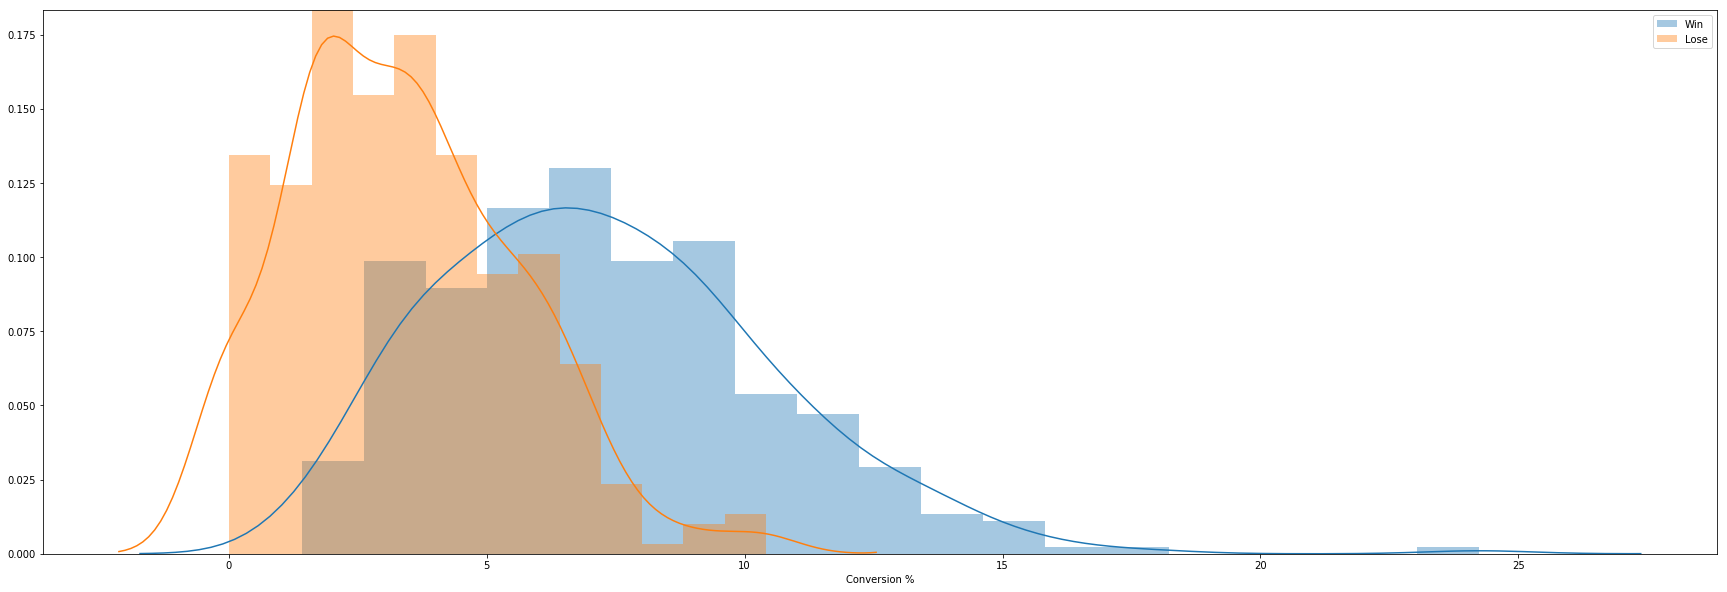

In [104]:
plt.figure(figsize=(30,10))
sns.distplot(corsi_df[corsi_df['Win']==1]['Conversion %'],label='Win')
sns.distplot(corsi_df[corsi_df['Win']==0]['Conversion %'],label='Lose')
plt.legend()

In [105]:
corsi_df[corsi_df['Win']==1]['Conversion %'].describe()

count    371.000000
mean       7.265057
std        3.244678
min        1.408451
25%        4.918033
50%        7.017544
75%        9.259259
max       24.242424
Name: Conversion %, dtype: float64

In [106]:
corsi_df[corsi_df['Win']==1]['Conversion %'].median()

7.017543859649122

In [107]:
corsi_df[corsi_df['Win']==0]['Conversion %'].describe()

count    371.000000
mean       3.367776
std        2.191309
min        0.000000
25%        1.694915
50%        3.174603
75%        4.761905
max       10.416667
Name: Conversion %, dtype: float64

In [108]:
corsi_df[corsi_df['Win']==0]['Conversion %'].median()

3.1746031746031744

Winning teams on average converted approximately 7% of shots to goals while losing teams convert approximately 3%

Lets look at conversion rates per game for the Toronto Maple Leafs

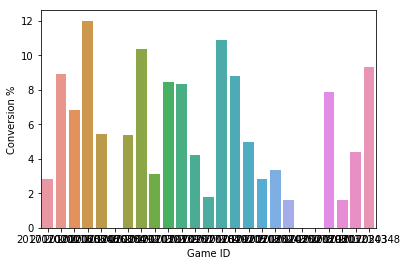

In [112]:
sns.barplot(x='Game ID',y='Conversion %',data=corsi_df[corsi_df['Team ID']=='10'])

Lets look at Corsi % per game for the Toronto Maple Leafs

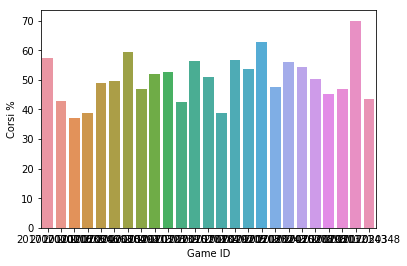

In [135]:
sns.barplot(x='Game ID',y='Corsi %',data=corsi_df[corsi_df['Team ID']=='10'])